<a href="https://colab.research.google.com/github/tejasnikumbh999/Item-Demand-Forecasting---Project/blob/main/Guvi_Project_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Item Demand Forecasting

---



###Problem Statement
Demand forecasts are fundamental to plan and deliver products and services. Accurate forecasting of demand can help the manufacturers to maintain appropriate stock which results in reduction in loss due to product not being sold and also reduces the opportunity cost (i.e. higher demand but less availability => opportunity lost). Despite such relevance, manufacturers have difficulty choosing which forecast model is the best for their use case. In this project, historical sales data corresponding to multiple(25) items sold in 10 stores are provided and participants are expected to come up with a best model to predict the future demand for products which results in maximum profit for the manufacturer. In general, the manufacturer incurs a loss of Rs. 10 for each item that is not sold (retention cost) and incurs an opportunity loss of Rs. 3 for excess demand. Predict the demand for the next 3 months at the item level (i.e. all the stores combined).




---

The end objective of the participant is to produce a model that gives the best profit to the manufacturer (i..e strikes a balance between the opportunity cost and retention cost). Such a model must include the seasonality of the items sold. 

---



#Import packages

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import statsmodels.api as sm
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

#Load data

In [ ]:
data = 'https://raw.githubusercontent.com/tejasnikumbh999/Training-datasets/main/train%202.csv'
df = pd.read_csv(data)
df.head()

#Exploratory Data Analysis (EDA)

In [ ]:
df_avg=df.groupby('date',as_index=False)['sales'].sum()
df_avg.head()

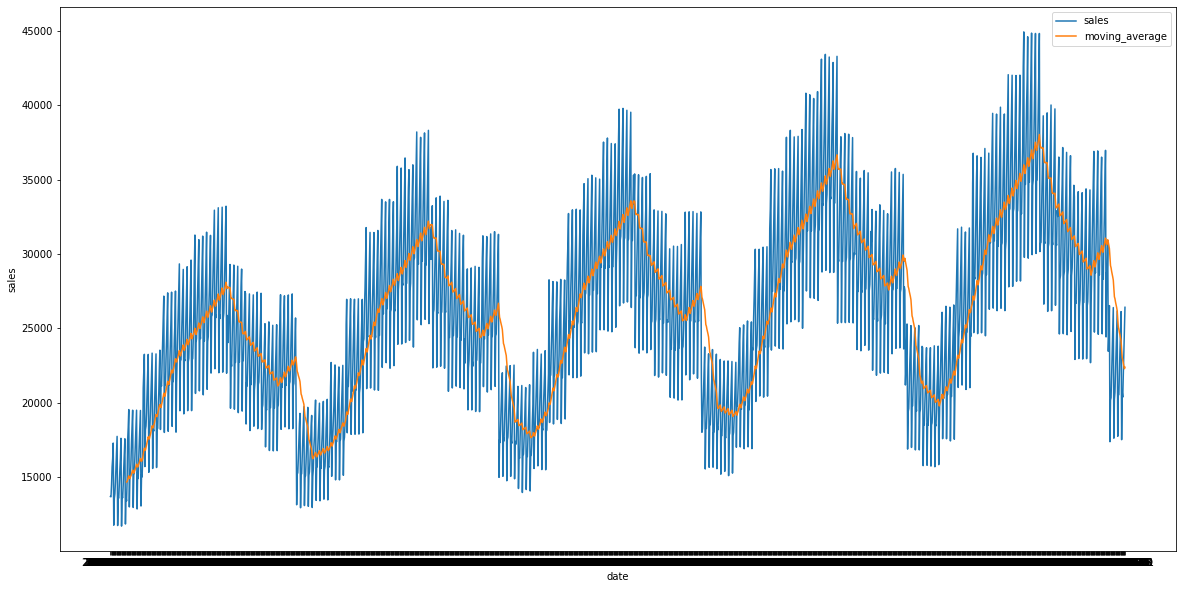

In [4]:
plt.figure( figsize = ( 20, 10))

sns.lineplot( x = 'date',y = 'sales',data = df_avg,label = 'sales')

df_avg['moving_average'] = df_avg['sales'].rolling(30).mean()

sns.lineplot( x = 'date',y = 'moving_average',data = df_avg,label = 'moving_average')

In [ ]:
df.shape

In [ ]:
df.size

- Data has 913000 rows and 4 columns

In [ ]:
df.dtypes

- Date is a object type, all other are integer type.

In [ ]:
df.isnull().sum()

- Data has no null value or missing values

In [ ]:
df.describe()

- Description of dataset

In [ ]:
print("Dataset starts at: ",df["date"].min()," date and end at ",df["date"].max()," date.")

###Time Series Decomposition

<Figure size 432x288 with 0 Axes>

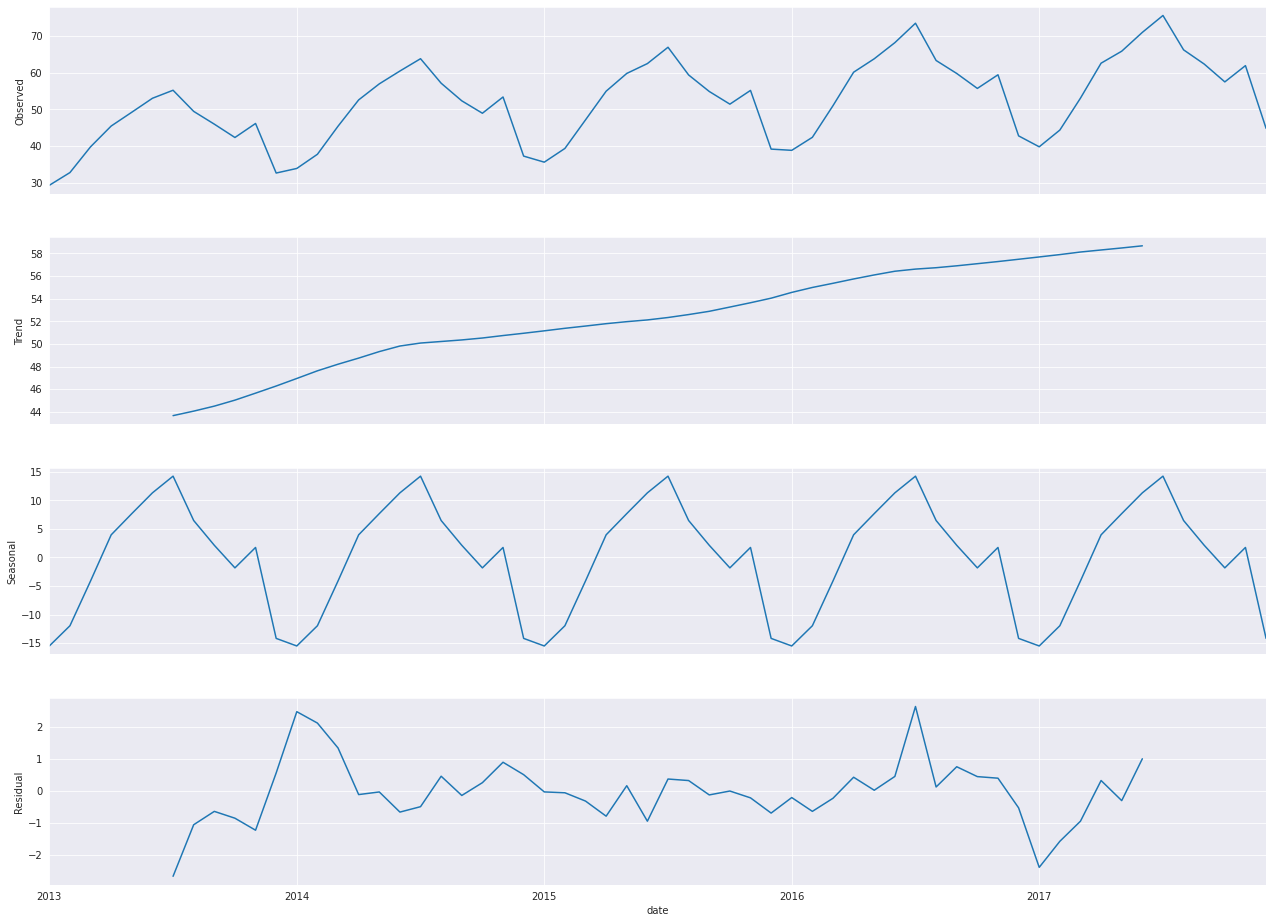

In [ ]:
df_plot = df.set_index('date')
y = df_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 15)

- Based on the:

1. 1st graph: the dataset is not stationary, it would be easier to have a future prediction simply by taking mean values if it was stationary.
2. 2nd graph: there is an increasing trend over time.
3. 3rd graph: a repeating pattern is observed, so there is seasonality- moving upwards on July.
4. 4th graph: residuals are decomposing randomly around 0, so the series is additive.

The end objective of the participant is to produce a model that gives the best profit to the manufacturer (i..e strikes a balance between the opportunity cost and retention cost). Such a model must include the seasonality of the items sold. 

#Feature Engineering

In [12]:
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df.date.dt.dayofweek
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df["is_weekend"] = df.date.dt.weekday // 5
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [13]:
#Add the Fiscal Quarters

df['Fiscal Quarter'] = pd.PeriodIndex(df['date'], freq='Q-MAR').strftime('%q')
df['Fiscal Quarter'] = pd.to_numeric(df['Fiscal Quarter'])

##Add the Fiscal Year

df['Fiscal Year'] = df['date'].dt.to_period('Q-APR').dt.qyear.apply(lambda x: str(x-1) + "-" + str(x))

In [ ]:
# Seasonality Features
# 0: Winter , 1: Autumn , 2: Summer , 3: Fall

df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
df["season"] = np.where(df.month.isin([3,4,5]), 2, df["season"])
df["season"] = pd.Series(np.where(df.month.isin([6,7,8,9]), 3, df["season"]))

df.head()

At this point, we add random noise to the variables that we will produce in the sales focus in order to prevent over-learning or to prevent bias. This will add noise prevents over-learning.

- day_of_week - 0 to 6 corresponds to days from Monday to Sunday.
- is_weekend - Saturday and Sunday are weekends (represented by 1).
- Fiscal Quarter - Year is divided into 4 fiscal quarters.
- Fiscal Year - fiscal year from April to March.



##Average Sales Statistics

In [ ]:
#sales distribution 

plt.figure(figsize=(15,15))
sns.set_style("darkgrid") 
ax = sns.distplot(df["sales"],kde=True,bins=8,color='green',hist_kws={"linewidth": 1,'alpha':0.83,'edgecolor':'#538','hatch':'o'})                     #add edge and hatch
ax.set(xlabel='Sales', ylabel='Frequency',title="Exponential Distribution")

- Sales data follows the Exponential Distribution.

In [ ]:
a=df['sales'].mean()
b=df['sales'].median()
c=df['sales'].std()
print(f'1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard deviation of sales is {c}.\n')

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(df["date"],df["sales"], color='green',s=20)
plt.title("Sales Data Time Series",fontsize=15)
plt.xlabel("date",fontsize=15)
plt.ylabel("Sales",fontsize=15)

In [ ]:
# Sales statistics per store and item
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

In [ ]:
# Yearly sales statistics per store and item
df.groupby(["store", "item", "year"]).agg({"sales": ["sum", "mean", "median", "std"]})

In [ ]:
# Monthly sales statistics per store and item
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

##Features Correlation

In [ ]:
plt.figure(figsize=(15,15))
cor = df.corr()
sns.heatmap(cor,annot=True,square=True,cmap=plt.cm.CMRmap_r)
plt.show()

##Sales statistics  - Item Wise

In [ ]:
x=int(input('Enter the Item Number (1 to 50) : \t'))

df_it=df.loc[df['item'] == x, ['sales','item']]

a=df_it['sales'].mean()
b=df_it['sales'].median()
c=df_it['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#total number of items and their sales

Total_it_sale=df.groupby('item',as_index=False)['sales'].sum()
Total_it_sale.head(2)

In [ ]:
#Item wise Sales

fig1= px.bar(Total_it_sale, x="item", y="sales",color="item", title="Item wise Sales",text_auto=True)
fig1.update_layout(xaxis = dict(tickmode = 'linear' ))
fig1.show()

In [ ]:
fig = px.box(df, x="item", y="sales", title="Item Wise Sales",color='item')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

#Item to be analysed

In [ ]:
x=int(input('Enter the Item Number (1 to 50) : \t'))

df_ite=df[df['item'] == x]

In [ ]:
df_ite

In [285]:
df_item=df_item.groupby(['date', 'day_of_week', 'day_of_month','day_of_year', 'week_of_year', 'month', 'year', 'is_weekend','is_month_start', 'is_month_end', 'Fiscal Quarter', 'Fiscal Year','season'])['sales'].sum().reset_index()

In [ ]:
df_item.set_index('date',inplace=True)
df_item

##Sales statistics  - Calender Year Wise

In [ ]:
x=int(input('Enter the Calender Year : \t'))

df_year=df_item.loc[df_item['year'] == x, ['sales','year']]

a=df_year['sales'].mean()
b=df_year['sales'].median()
c=df_year['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Yearly Total sales

Total_Yearly_sale=df_item.groupby('year',as_index=False)['sales'].sum()
Yearly_Perc_sales_change=Total_Yearly_sale['sales'].pct_change()
Yearly_Perc_sales_change.drop(0,inplace=True)
YOY_Sales = px.bar(Total_Yearly_sale,x='year',y='sales', title="Total Yearly Sales",color='year',text_auto=True)
YOY_Sales

In [ ]:
fig = px.box(df_item, x="year", y="sales", title="Yearly sales",color='year')
fig.show()

In [ ]:
fig = px.bar(Yearly_Perc_sales_change*100, title="Percentage change in sales Year-over-Year",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = [1,2,3,4],ticktext = ['2013 -2014', '2014 -2015', '2015 -2016', '2016 -2017']))
fig.show()

##Sales statistics  - Fiscal Year Wise

In [ ]:
x=input('Enter the Fiscal Year : \t')

df_fyear=df_item.loc[df_item['Fiscal Year'] == x, ['sales','Fiscal Year']]

a=df_fyear['sales'].mean()
b=df_fyear['sales'].median()
c=df_fyear['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Fiscal Yearly Total sales

Total_Fiscal_Yearly_sale=df_item.groupby('Fiscal Year',as_index=False)['sales'].sum()
FYearly_Perc_sales_change=Total_Fiscal_Yearly_sale['sales'].pct_change()
FYearly_Perc_sales_change.drop(0,inplace=True)
FYoFY_Sales = px.bar(Total_Fiscal_Yearly_sale,x='Fiscal Year',y='sales', title="Total Fiscal Yearly Sales",color='Fiscal Year')
FYoFY_Sales

In [ ]:
fig = px.box(df_item, x="Fiscal Year", y="sales", title="Fiscal Yearly sales",color='Fiscal Year')
fig.show()

In [ ]:
fig = px.bar(FYearly_Perc_sales_change*100, title="Percentage change in sales Fiscal Year-over-Year",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

##Sales statistics  - Fiscal Quarter Wise

In [ ]:
x=int(input('Enter the Fiscal Quarter (1 to 4): \t'))

df_fquarter=df_item.loc[df_item['Fiscal Quarter'] == x, ['sales','Fiscal Quarter']]

a=df_fquarter['sales'].mean()
b=df_fquarter['sales'].median()
c=df_fquarter['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Fiscal Quarterly Total sales

Total_Fiscal_Quarterly_sale=df_item.groupby('Fiscal Quarter',as_index=False)['sales'].sum()
Quarterly_Perc_sales_change=Total_Fiscal_Quarterly_sale['sales'].pct_change()
Quarterly_Perc_sales_change.drop(0,inplace=True)
QoQ_Sales = px.pie(Total_Fiscal_Quarterly_sale,values='sales',names='Fiscal Quarter', title="Total Fiscal Quarterly Sales",color='Fiscal Quarter')
QoQ_Sales

In [ ]:
fig = px.box(df_item, x="Fiscal Quarter", y="sales", title="Fiscal Quarterly sales",color='Fiscal Quarter')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
fig = px.bar(Quarterly_Perc_sales_change*100, title="Percentage change in sales Fiscal Quarter-over-Quarter",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

##Sales statistics  - MonthWise

In [ ]:
x=int(input('Enter the Calender Month (1 to 12) : \t'))

df_month=df_item.loc[df_item['month'] == x, ['sales','month']]

a=df_month['sales'].mean()
b=df_month['sales'].median()
c=df_month['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Monthly Total sales

Total_Monthly_sale=df_item.groupby('month',as_index=False)['sales'].sum()
Monthly_Perc_sales_change=Total_Monthly_sale['sales'].pct_change()
Monthly_Perc_sales_change.drop(0,inplace=True)
MOM_Sales = px.bar(Total_Monthly_sale,x='month',y='sales', title="Total Monthly Sales",color='month',text_auto=True)
MOM_Sales

In [ ]:
fig = px.box(df_item, x="month", y="sales", title="Monthly sales",color='month')
fig.show()

In [ ]:
fig = px.bar(Monthly_Perc_sales_change*100, title="Percentage change in sales Month-over-Month",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array'))
fig.show()

##Sales statistics  - Week of Year Wise

In [ ]:
x=int(input('Enter the Week of Year : \t'))

df_weeky=df_item.loc[df_item['week_of_year'] == x, ['sales','week_of_year']]

a=df_weeky['sales'].mean()
b=df_weeky['sales'].median()
c=df_weeky['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Weekly Total sales

Total_Weekly_sale=df_item.groupby('week_of_year',as_index=False)['sales'].sum()
Weekly_Perc_sales_change=Total_Weekly_sale['sales'].pct_change()
Weekly_Perc_sales_change.drop(0,inplace=True)
WOW_Sales = px.bar(Total_Weekly_sale,x='week_of_year',y='sales', title="Total Weekly Sales",color='week_of_year',text_auto=True)
WOW_Sales

In [ ]:
fig = px.box(df_item, x="week_of_year", y="sales", title="Weekly sales",color='week_of_year')
fig.show()

In [ ]:
fig = px.bar(Weekly_Perc_sales_change*100, title="Percentage change in sales Week-over-Week",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array'))
fig.show()

##Sales statistics  - Day of year Wise

In [ ]:
x=int(input('Enter the Day of year (1 to 365) : \t'))

df_dayy=df_item.loc[df_item['day_of_year'] == x, ['sales','day_of_year']]

a=df_dayy['sales'].mean()
b=df_dayy['sales'].median()
c=df_dayy['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Daily Total sales

Daily_sale=df_item.groupby('day_of_year',as_index=False)['sales'].sum()
Daily_Perc_sales_change=Daily_sale['sales'].pct_change()
Daily_Perc_sales_change.drop(0,inplace=True)
Daily_Sales = px.bar(Daily_sale,x='day_of_year',y='sales', title='Total Daily Sales',color='day_of_year')
Daily_Sales.update_layout(xaxis = dict(tickmode = 'linear' ))
Daily_Sales

In [ ]:
fig = px.box(df_item, x="day_of_year", y="sales", title="Day Wise Sales",color='day_of_year')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
fig = px.bar(Daily_Perc_sales_change*100, title="Percentage change in sales Day-Over-Day",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array'))
fig.show()

##Sales statistics  - Day of Month Wise

In [ ]:
x=int(input('Enter the Day of Month (1 to 31) : \t'))

df_daym=df_item.loc[df_item['day_of_month'] == x, ['sales','day_of_month']]

a=df_daym['sales'].mean()
b=df_daym['sales'].median()
c=df_daym['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Daily Total sales

Daily_sale=df_item.groupby('day_of_month',as_index=False)['sales'].sum()
Daily_Perc_sales_change=Daily_sale['sales'].pct_change()
Daily_Perc_sales_change.drop(0,inplace=True)
Daily_Sales = px.bar(Daily_sale,x='day_of_month',y='sales', title='Total Daily Sales',color='day_of_month')
Daily_Sales.update_layout(xaxis = dict(tickmode = 'linear' ))
Daily_Sales

In [ ]:
fig = px.box(df_item, x="day_of_month", y="sales", title="Day Wise Sales",color='day_of_month')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
fig = px.bar(Daily_Perc_sales_change*100, title="Percentage change in sales Day-Over-Day",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array'))
fig.show()

##Sales statistics  - Week Day Wise

In [ ]:
x=int(input('Enter the Day of Week (0 to 6): \t'))

df_dayw=df_item.loc[df_item['day_of_week'] == x, ['sales','day_of_week']]

a=df_dayw['sales'].mean()
b=df_dayw['sales'].median()
c=df_dayw['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#Daily Total sales

Daily_sale=df_item.groupby('day_of_week',as_index=False)['sales'].sum()
Daily_Perc_sales_change=Daily_sale['sales'].pct_change()
Daily_Perc_sales_change.drop(0,inplace=True)
Daily_Sales = px.bar(Daily_sale,x='day_of_week',y='sales', title='Total Daily Sales',color='day_of_week')
Daily_Sales.update_layout(xaxis = dict(tickmode = 'linear' ))
Daily_Sales

In [ ]:
fig = px.box(df_item, x="day_of_week", y="sales", title="Day Wise Sales",color='day_of_week')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
fig = px.bar(Daily_Perc_sales_change*100, title="Percentage change in sales Day-Over-Day",color='value',text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array'))
fig.show()

- It can be observed that the sales on Friday Saturday and Sunday are higher compared to other days of week, with the maximum sales comes on Sunday.

##Sales statistics  - Season Wise

In [ ]:
x=int(input('Enter the Season (0: Winter , 1: Autumn , 2: Summer , 3: Fall) : \t'))

df_season=df_item.loc[df_item['season'] == x, ['sales','season']]

a=df_season['sales'].mean()
b=df_season['sales'].median()
c=df_season['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#total number of store and their sales

Total_season_sale=df_item.groupby('season',as_index=False)['sales'].sum()
Total_season_sale.head()

In [ ]:
#season wise sales

fig = px.bar(Total_season_sale, x="season", y="sales",color="season", title="Seasonal Sales",text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = [0,1,2,3],ticktext = ['Winter','Autumn','Summer','Fall']))
fig.show()

- It can be observed that the sales folows the seasonal trend with least sales in winter, while the maximum sales are from fall(Monson).

In [ ]:
fig = px.box(df_item, x="season", y="sales", title="Seasonal Sales",color='season')
fig.update_layout(xaxis = dict(tickmode = 'array',tickvals = [0,1,2,3],ticktext = ['Winter','Autumn','Summer','Fall']))
fig.show()

- Highest sales are from Fall season.

##Sales statistics  - Store Wise

In [ ]:
x=int(input('Enter the Store Number (1 to 10) : \t'))

df_store=df_item.loc[df_item['store'] == x, ['sales','store']]

a=df_store['sales'].mean()
b=df_store['sales'].median()
c=df_store['sales'].std()
print(f'\n1. The mean sales is {a}.\n')
print(f'1. The median sales is {b}.\n')
print(f'1. The standard daviation of sales is {c}.\n')

In [ ]:
#total number of store and their sales

Total_store_sale=df_item.groupby('store',as_index=False)['sales'].sum()
Total_store_sale.head(2)

In [ ]:
#store wise sales

fig = px.bar(Total_store_sale, x="store", y="sales",color="store", title="Store wise Sales",text_auto=True)
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
fig = px.box(df_item, x="store", y="sales", title="Store Wise Sales",color='store')
fig.update_layout(xaxis = dict(tickmode = 'linear' ))
fig.show()

In [ ]:
#90 day rolling sum of sales
df_roll=df_item.groupby(['date'])['sales'].sum()
df_roll=df_roll.to_frame()
df_roll['90days sales']=df_roll['sales'].rolling(90).sum().shift(-89)
df_roll.dropna()
df_roll.drop(['sales'],axis=1,inplace=True)
df_roll.plot(figsize=(12,4),title=('90 days rolling sales'))

#Machine Learning Algorithm

In [ ]:
df_item.columns

In [410]:
#add 90 days rolling mean sales to predict future sales for next 3 months

df_item['90 days sales']=df_item['sales'].rolling(90).sum().shift(-89)

In [ ]:
df_item.dropna(inplace=True)
df_item

In [412]:
#select features and target
x=df_item.drop(columns=['sales','Fiscal Year','week_of_year','day_of_year','90 days sales','day_of_week','is_weekend','is_month_start', 'is_month_end'])
y=df_item['90 days sales']

#split  train and test data
#split test:train in ratio 80:20

x_train=x.iloc[:int(x.shape[0]*0.8)]
x_test=x.iloc[int(x.shape[0]*0.8):]

y_train=y.iloc[:int(x.shape[0]*0.8)]
y_test=y.iloc[int(x.shape[0]*0.8):]

- Data is split as 80% for training and 20% for testing.

##ML Algorithm

In [414]:
def predict_plot(model,title):
    model.fit(x_train,y_train)
    pred=model.predict(x_test)
    yt=y_test.to_frame()
    yt['prediction']=pred
    yt.plot(ylabel='sales',title=title)
    print('The r2 score achieved using '+title+' is',r2_score(y_test,pred))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
xgb=xgb.XGBRegressor()
from sklearn.ensemble import AdaBoostRegressor

predict_plot(LinearRegression(),'LinearRegression')
predict_plot(knn,'KNeighborsRegression')
predict_plot(DecisionTreeRegressor(),'DecisionTree')
predict_plot(xgb,'XGBoost')
predict_plot(AdaBoostRegressor(),'AdaBoostRegressor')
predict_plot(RandomForestRegressor(),'RandomForest')

- Best Machine Learning Model is Random Forest Regressor with r2 above 95%

#Feature Importance

In [ ]:
classifier = RandomForestRegressor(n_estimators = 100, random_state = 0)
classifier.fit(x_train,y_train)
feature_scores = pd.Series(classifier.feature_importances_,index=x_train.columns).sort_values(ascending=False)
feature_scores = feature_scores*100
feature_scores

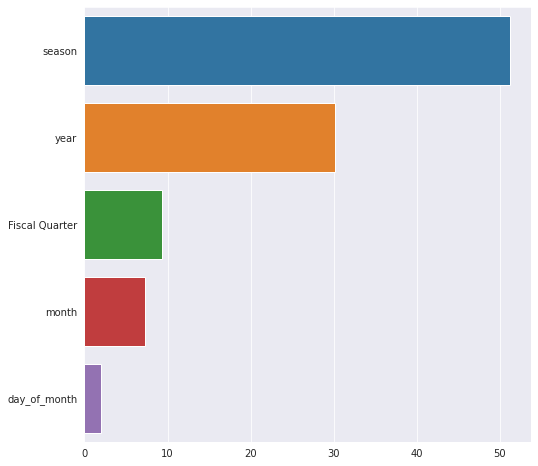

In [419]:
#plotting the feature importance
plt.figure(figsize=(8,8))
sns.barplot(x=feature_scores,y=feature_scores.index)

Above Bar plot shows the feature importance for predicting the sales.

#Dimentionality Reduction - PCA

In [ ]:
from sklearn.decomposition import PCA
pca= PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

##PCA with Random Forest

In [369]:
pca=PCA(n_components=4)  
x_new=pca.fit_transform(x_train)
x_new
x_te=pca.fit_transform(x_test)
x_te
pca.explained_variance_ratio_

array([0.84349297, 0.12782849, 0.02396308, 0.00450403])

In [370]:
from sklearn.ensemble import RandomForestRegressor

classifier = RandomForestRegressor(n_estimators = 10, random_state = 0)
classifier.fit(x_new,y_train)

#model score
Random_score=classifier.score(x_te,y_test)
print('\nRandom forest model score : \t', Random_score*100,' %')

#predict y using x as input for the model
y_pred = classifier.predict(x_te)

#error metrices
r2_score(y_test,y_pred)


Random forest model score : 	 31.838155463298136  %


0.31838155463298135

- The PCA analysis is not suitable for the preesent case as it has very low r2 score(i.e 31%)

#Predicting Future Sales

In [438]:
x=int(input('Enter the Item Number (1 to 50) : \t'))

df_ite=df[df['item'] == x]
df_item=df_item.groupby(['date', 'day_of_week', 'day_of_month','day_of_year', 'week_of_year', 'month', 'year', 'is_weekend','is_month_start', 'is_month_end', 'Fiscal Quarter', 'Fiscal Year','season'])['sales'].sum().reset_index()
df_item.set_index('date',inplace=True)
df_item
#add 90 days rolling mean sales to predict future sales for next 3 months

df_item['90 days sales']=df_item['sales'].rolling(90).sum().shift(-89)
df.dropna(inplace=True)

#select features and target
x=df_item.drop(columns=['sales','Fiscal Year','week_of_year','day_of_year','90 days sales','day_of_week','is_weekend','is_month_start', 'is_month_end'])
y=df_item['90 days sales']

#split  train and test data
#split test:train in ratio 80:20

x_train=x.iloc[:int(x.shape[0]*0.8)]
x_test=x.iloc[int(x.shape[0]*0.8):]

y_train=y.iloc[:int(x.shape[0]*0.8)]
y_test=y.iloc[int(x.shape[0]*0.8):]

classifier = RandomForestRegressor(n_estimators = 100, random_state = 0)
classifier.fit(x_train,y_train)

import datetime
date_entry = input('Enter a date in YYYY-MM-DD format : \t')
year, month, day = map(int, date_entry.split('-'))
date1 = datetime.date(year, month, day)
x=[date1.day,date1.month,date1.year]

if date1.month==1 or date1.month==2 or date1.month==3:
  x.append(4)
elif date1.month==4 or date1.month==5 or date1.month==6:
  x.append(1)
elif date1.month==7 or date1.month==8 or date1.month==9:
  x.append(2)
else:
  x.append(3)

if date1.month==12 or date1.month==1 or date1.month==2:
  x.append(0)
elif date1.month==10 or date1.month==11:
  x.append(1)
elif date1.month==3 or date1.month==4 or date1.month==5:
  x.append(2)
else:
  x.append(3)
print(f'\nThe predicted three months sales for the date {date1} is : {round(classifier.predict([x])[0])} items.')

print(f'\nThe predicted three months sales for the date {date1} with a 10 % range is : {round(classifier.predict([x])[0]-0.1*classifier.predict([x])[0])} to {round(classifier.predict([x])[0]+0.1*classifier.predict([x])[0])} items.')


Enter the Item Number (1 to 50) : 	1
Enter a date in YYYY-MM-DD format : 	2019-01-01

The predicted three months sales for the date 2019-01-01 is : 16635 items.

The predicted three months sales for the date 2019-01-01 with a 10% range is : 14971 to 18298 items.
